# Group A - O1

**Importing the required libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import scale, StandardScaler, Binarizer, MinMaxScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_selection import f_classif,chi2, SelectPercentile, SelectFromModel, RFE, SelectKBest
import warnings 
warnings.filterwarnings("ignore")
import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV

**Loading the train and test files into a DataFrame:**

In [2]:
train = pd.read_csv("train_santander.csv")
test = pd.read_csv("test_santander.csv")
test_final = pd.read_csv("test_santander.csv")

**Removing constant columns (std = 0)**


In [3]:
remove = []
for col in train.columns:
    if train[col].std() == 0:
        remove.append(col)

train.drop(remove, axis=1, inplace=True)
test.drop(remove, axis=1, inplace=True)

**Removing duplicated columns**

In [4]:
remove = []
cols = train.columns
for i in range(len(cols)-1):
    v = train[cols[i]].values
    for j in range(i+1,len(cols)):
        if np.array_equal(v,train[cols[j]].values):
            remove.append(cols[j])

train.drop(remove, axis=1, inplace=True)
test.drop(remove, axis=1, inplace=True)

**Let's take a look at some of the variables' histograms to check whether they need some transformations or not**

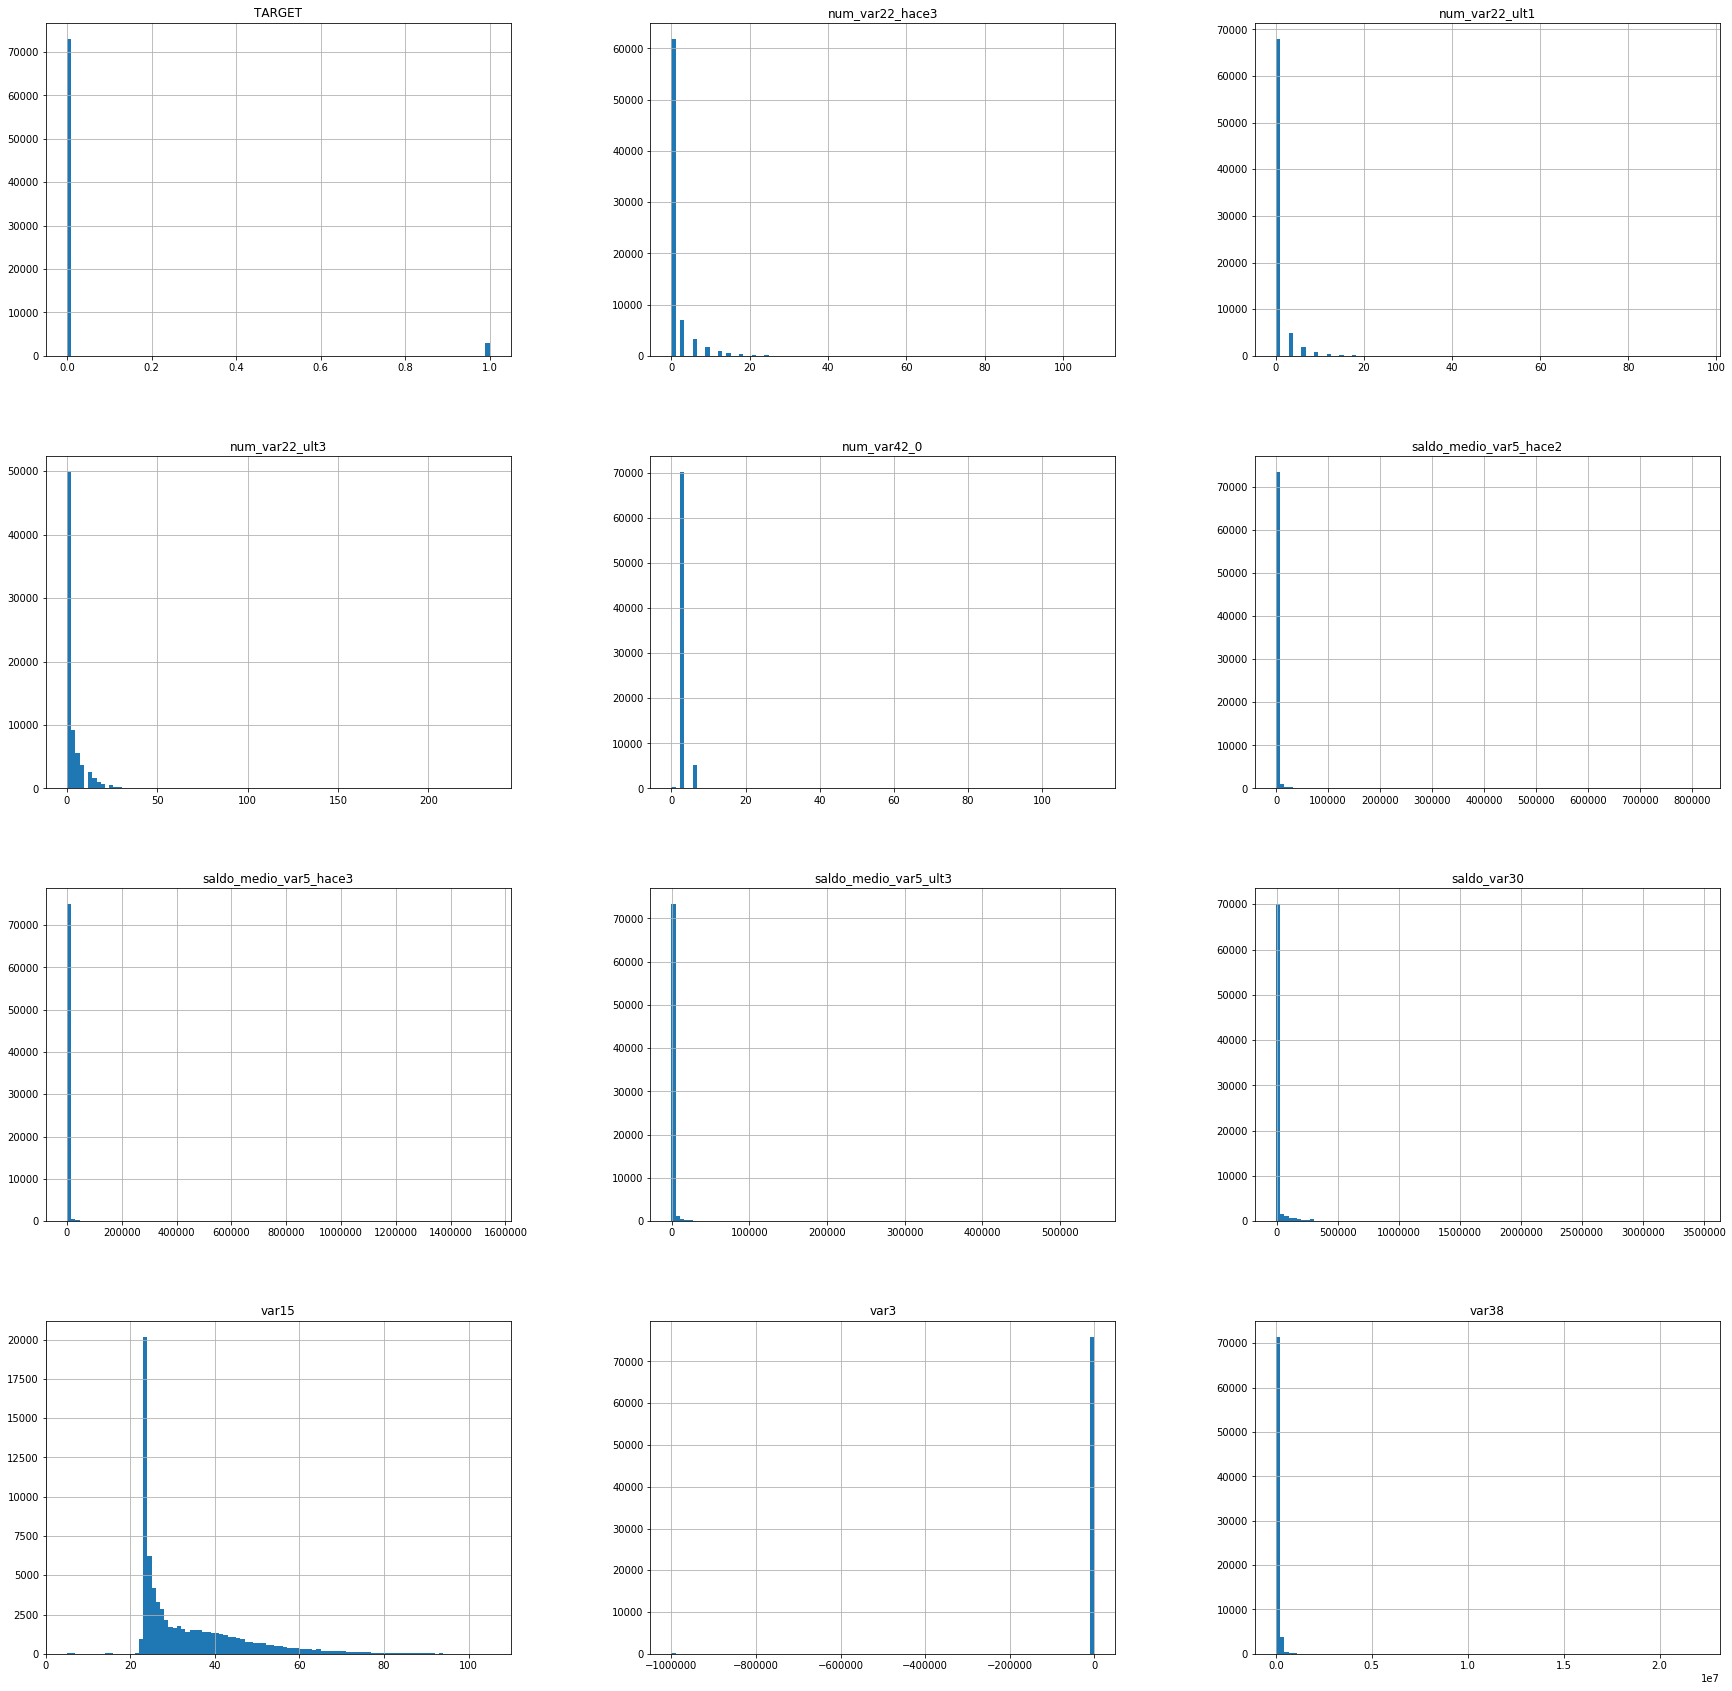

In [5]:
%matplotlib inline
train[['var3', 'var15', 'saldo_var30', 'saldo_medio_var5_hace2', 'saldo_medio_var5_hace3',
       'num_var22_ult1', 'num_var22_ult3', 'num_var42_0', 'num_var22_hace3',
       'var38','saldo_medio_var5_ult3','TARGET']].hist(figsize=(30, 30),  bins=100)
plt.show()

**We will transform tha variables var38 and var15 into logarithms**

In [6]:
train.var38 = np.log(train.var38)
test.var38 = np.log(test.var38)
train.var15 = np.log(train.var15)
test.var15 = np.log(test.var15)

**We noticed that variables containing the value 999999 most probably are NA's**

In [7]:
print((train == -999999).sum()[:10])

ID                           0
var3                       116
var15                        0
imp_ent_var16_ult1           0
imp_op_var39_comer_ult1      0
imp_op_var39_comer_ult3      0
imp_op_var40_comer_ult1      0
imp_op_var40_comer_ult3      0
imp_op_var40_efect_ult1      0
imp_op_var40_efect_ult3      0
dtype: int64


In [8]:
print((test == -999999).sum()[:10])

ID                           0
var3                       120
var15                        0
imp_ent_var16_ult1           0
imp_op_var39_comer_ult1      0
imp_op_var39_comer_ult3      0
imp_op_var40_comer_ult1      0
imp_op_var40_comer_ult3      0
imp_op_var40_efect_ult1      0
imp_op_var40_efect_ult3      0
dtype: int64


**We replace the values 999999 with 0**

In [9]:
train.var3 = train['var3'].replace(-999999,0)
test.var3 = test['var3'].replace(-999999,0)

**Now we can take another look on the variables we transformed**

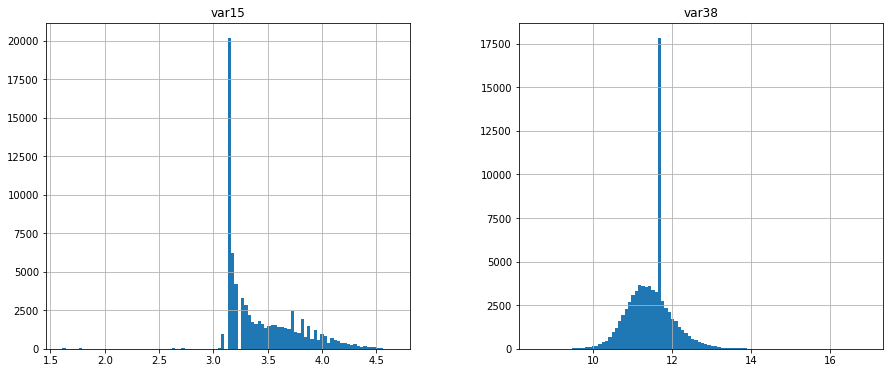

In [10]:
%matplotlib inline
train[['var38', 'var15']].hist(figsize=(15, 6),  bins=100)
plt.show()

In [11]:
train['var3'].value_counts()[:10]

2     74165
0       191
8       138
9       110
3       108
1       105
13       98
7        97
4        86
12       85
Name: var3, dtype: int64

In [12]:
test['var3'].value_counts()[:10]

2     73962
0       196
8       116
9       108
13      107
3       107
1        99
10       85
11       85
12       83
Name: var3, dtype: int64

**Spliting data into train and test**

In [13]:
test_id = test.ID
test = test.drop(["ID"],axis=1)

X = train.drop(["TARGET","ID"],axis=1)
y = train.TARGET.values

**Lets take a look at the importance of the variables according to XGBoost**

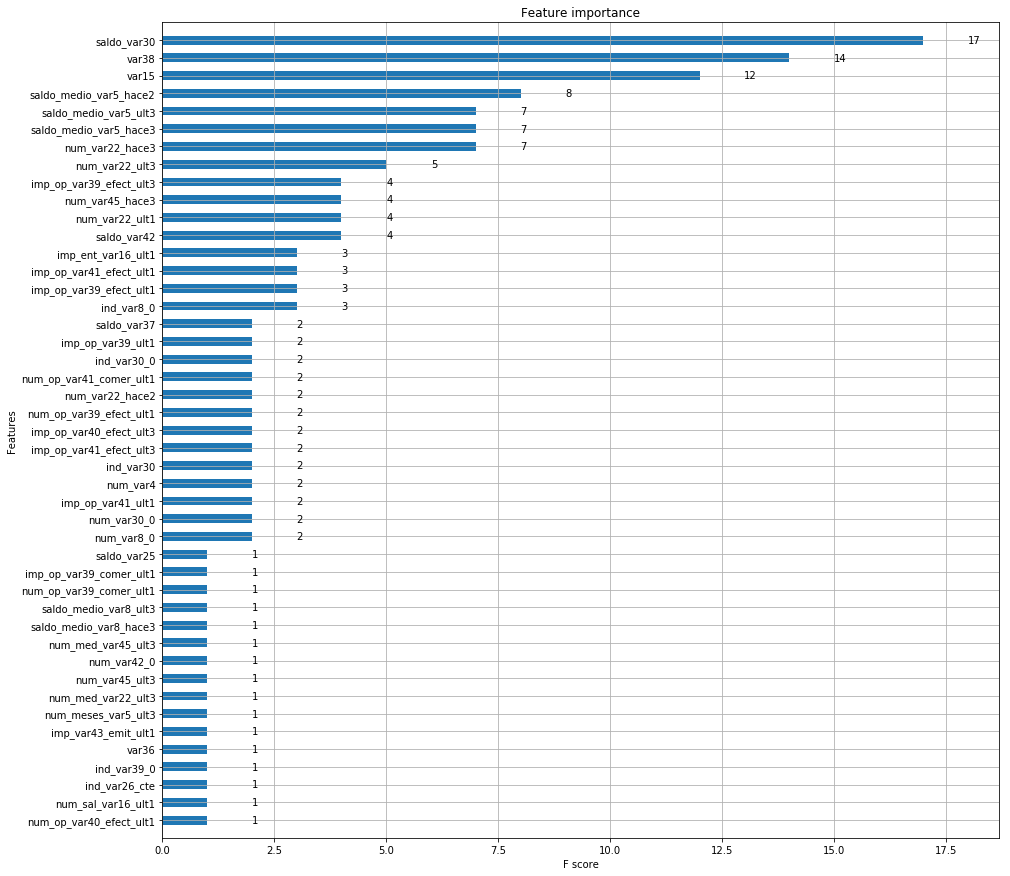

In [14]:
# Create the DMatrix: housing_dmatrix
housing_dmatrix = xgb.DMatrix(data=X, label=y)

# Create the parameter dictionary: params
params = {"objective":'binary:logistic',"max_depth":4, "n_estimators":110, "colsample_bytree":0.5}

# Train the model: xg_reg
xg_reg = xgb.train(params=params, dtrain=housing_dmatrix, num_boost_round=10)

# Plot the feature importances
%matplotlib inline
fig, ax = plt.subplots(figsize=(15, 15))
xgb.plot_importance(xg_reg, max_num_features=50, height=0.5, ax=ax)
plt.show()

**We can now create the training and test sets**

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=42, stratify=y)

**Checking the number of columns rows**

In [16]:
print(X_train.shape, X_test.shape, test.shape)

(68418, 306) (7602, 306) (75818, 306)


**We are going to use the XGBoostClassifier to select the features that we are going to use in our model**

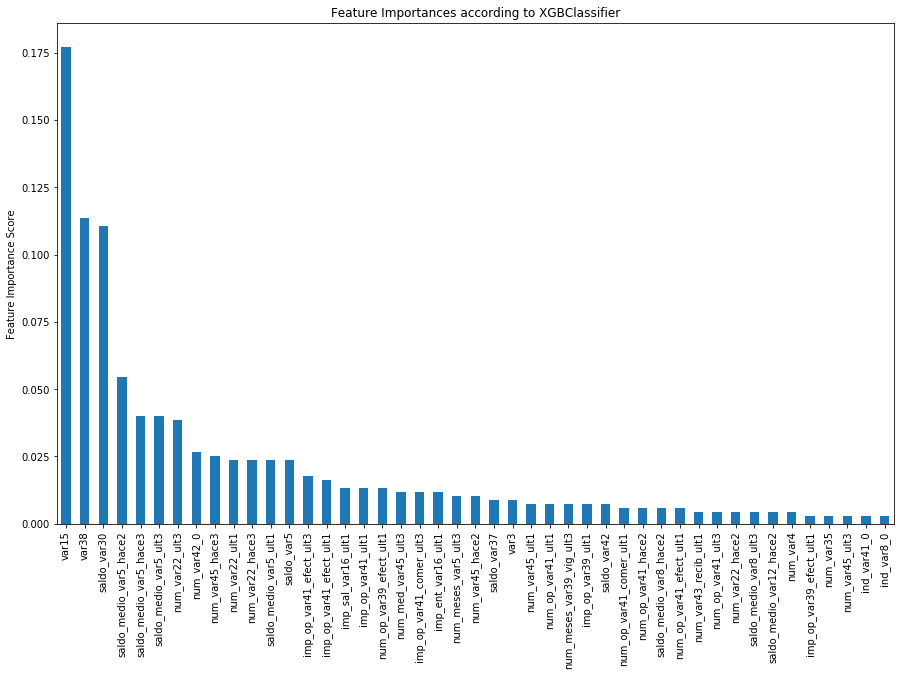

In [17]:
## # Feature selection
flc = xgb.XGBClassifier(random_state=42)
selector = flc.fit(X_train, y_train)

# plot most important features
feat_imp = pd.Series(flc.feature_importances_, index = X_train.columns.values).sort_values(ascending=False)
feat_imp[:45].plot(kind='bar', title='Feature Importances according to XGBClassifier', figsize=(15, 12))
plt.ylabel('Feature Importance Score')
plt.subplots_adjust(bottom=0.3)
plt.show()

**Now, we transform our data using only the features that XGBoost selected.
After that, we'll check the new number of columns and rows**

In [18]:
# clf.feature_importances_ 
fs = SelectFromModel(selector, prefit=True)

X_train = fs.transform(X_train)
X_test = fs.transform(X_test)
test = fs.transform(test)

print(X_train.shape, X_test.shape, test.shape)

(68418, 40) (7602, 40) (75818, 40)


**Converting the training and testing sets into DMatrixes: DM_train, DM_test**

In [19]:
DM_train = xgb.DMatrix(data=X_train, label=y_train)
DM_test =  xgb.DMatrix(data=X_test, label=y_test)

**Instead of attempting to cherry pick the best possible number of boosting rounds, we can very easily have XGBoost automatically select the number of boosting rounds for us within xgb.cv(). This is done using a technique called early stopping**

In [20]:
# Perform cross-validation with early stopping: cv_results
params = {"objective":'binary:logistic'}
cv_results = xgb.cv(dtrain=DM_train, params=params, nfold=3, metrics="auc", 
                    as_pandas=True, early_stopping_rounds=50, seed=42)
# Print cv_results
print(cv_results)

   test-auc-mean  test-auc-std  train-auc-mean  train-auc-std
0       0.805829      0.013139        0.820727       0.005634
1       0.814937      0.012987        0.832935       0.006198
2       0.819025      0.012663        0.838762       0.003881
3       0.824414      0.012913        0.845398       0.003741
4       0.826924      0.012351        0.849471       0.003326
5       0.828601      0.011603        0.854185       0.003406
6       0.830426      0.011054        0.858030       0.004014
7       0.831335      0.010440        0.862273       0.004108
8       0.832100      0.010827        0.865511       0.004647
9       0.833581      0.011299        0.869391       0.004142


**In order to tune some of the parameters of our model we are going to use RandomizedSearchCV**

In [21]:
# Create the parameter grid: gbm_param_grid 
gbm_param_grid = {
    'colsample_bytree': [0.5, 0.7, 0.8],
    'n_estimators': [25, 50, 110, 200],
    'max_depth': range(2, 6),
    'colsample_bylevel': [0.1, 0.5, 1],
    'gamma': range(0, 25),
    'min_child_weight': range(0, 10),
    'learning_rate': [0.001, 0.01, 0.02, 0.05, 0.1]
    }

# Instantiate the regressor: gbm
gbm = xgb.XGBClassifier()

# Perform random search: grid_auc
randomized_auc = RandomizedSearchCV(estimator=gbm, param_distributions=gbm_param_grid,
                                    scoring="roc_auc", n_iter=5, cv = 4, verbose=False)


# Fit randomized_mse to the data
randomized_auc.fit(X_train, y_train)

# Print the best parameters and lowest RMSE
print("Best parameters found: ", randomized_auc.best_params_)
print("Highest AUC found: ", randomized_auc.best_score_)


Best parameters found:  {'n_estimators': 110, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 2, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.5}
Highest AUC found:  0.8385217640293814


**We will do it manually for other parameters, in this case we are checking the L2 regularization term on weights, increasing this value will make model more conservative**

In [22]:
auc_params = np.arange(0.5, 10, 0.5)

# Create the initial parameter dictionary for varying l2 strength: params
params = {"objective":'binary:logistic', 'n_estimators':110, 'min_child_weight':5, "max_depth":5,
         'learning_rate':0.05, 'gamma':2, 'colsample_bytree':0.8, 'colsample_bylevel':0.05}

# Create an empty list for storing rmses as a function of l2 complexity
aucs_l2 = []

# Iterate over reg_params
for reg in auc_params:

    # Update l2 strength
    params["reg_lambda"] = reg
    
    # Pass this updated param dictionary into cv
    cv_results_auc = xgb.cv(dtrain=DM_train, params=params, nfold=2, 
                             num_boost_round=8, metrics="auc", as_pandas=True, seed=42)
    
    # Append best rmse (final round) to rmses_l2
    aucs_l2.append(cv_results_auc["test-auc-mean"].tail(1).values[0])

# Look at best rmse per l2 param
print("Best auc as a function of l2:")
print(pd.DataFrame(list(zip(auc_params, aucs_l2)), columns=["l2", "auc"]))


Best auc as a function of l2:
     l2       auc
0   0.5  0.708589
1   1.0  0.718132
2   1.5  0.714883
3   2.0  0.696124
4   2.5  0.692633
5   3.0  0.691651
6   3.5  0.691651
7   4.0  0.691682
8   4.5  0.691682
9   5.0  0.692753
10  5.5  0.692792
11  6.0  0.690292
12  6.5  0.688823
13  7.0  0.687055
14  7.5  0.718102
15  8.0  0.718102
16  8.5  0.718102
17  9.0  0.718102
18  9.5  0.689675


**In this case we are checking the L1 regularization term on weights, increasing this value will make model more conservative**

In [23]:
auc_params = np.arange(0.1, 1, 0.01)

# Create the initial parameter dictionary for varying l2 strength: params
params = {"objective":'binary:logistic', 'n_estimators':110, 'min_child_weight':5, "max_depth":5,
         'learning_rate':0.05, 'gamma':2, 'colsample_bytree':0.8, 'colsample_bylevel':0.05, 'reg_lambda':7.5}

# Create an empty list for storing rmses as a function of l2 complexity
aucs_l2 = []

# Iterate over reg_params
for reg in auc_params:

    # Update l2 strength
    params["reg_alpha"] = reg
    
    # Pass this updated param dictionary into cv
    cv_results_auc = xgb.cv(dtrain=DM_train, params=params, nfold=2, 
                             num_boost_round=8, metrics="auc", as_pandas=True, seed=42)
    
    # Append best rmse (final round) to rmses_l2
    aucs_l2.append(cv_results_auc["test-auc-mean"].tail(1).values[0])

# Look at best rmse per l2 param
print("Best auc as a function of l1:")
print(pd.DataFrame(list(zip(auc_params, aucs_l2)), columns=["l1", "auc"]))


Best auc as a function of l1:
      l1       auc
0   0.10  0.718102
1   0.11  0.718102
2   0.12  0.718102
3   0.13  0.718102
4   0.14  0.718102
5   0.15  0.718102
6   0.16  0.718102
7   0.17  0.718102
8   0.18  0.718102
9   0.19  0.718102
10  0.20  0.718102
11  0.21  0.718102
12  0.22  0.718102
13  0.23  0.718102
14  0.24  0.718102
15  0.25  0.718102
16  0.26  0.718102
17  0.27  0.718102
18  0.28  0.685558
19  0.29  0.685558
20  0.30  0.685558
21  0.31  0.685558
22  0.32  0.685558
23  0.33  0.685558
24  0.34  0.685558
25  0.35  0.685558
26  0.36  0.685558
27  0.37  0.685558
28  0.38  0.685558
29  0.39  0.685558
..   ...       ...
60  0.70  0.685558
61  0.71  0.685558
62  0.72  0.685558
63  0.73  0.689675
64  0.74  0.689675
65  0.75  0.689675
66  0.76  0.689675
67  0.77  0.689675
68  0.78  0.689675
69  0.79  0.689675
70  0.80  0.689675
71  0.81  0.689675
72  0.82  0.689675
73  0.83  0.689675
74  0.84  0.689675
75  0.85  0.689675
76  0.86  0.689675
77  0.87  0.689675
78  0.88  0.689675
7

**Now we are going to check whether scaling out data improves our model or not**

In [24]:
# Setup the pipeline steps: steps
steps = [('scaler', StandardScaler()),
        ('Xgb', xgb.XGBClassifier(n_estimators=110, objective='binary:logistic', colsample_bytree=0.5, gamma=4,
                                  max_depth = 4, num_boost_round=9, seed=42))]

# Create the pipeline: pipeline
pipeline = Pipeline(steps)

# Fit the pipeline to the training set: knn_scaled
Xgb_scaled = pipeline.fit(X_train, y_train)

# Instantiate and fit a k-NN classifier to the unscaled data
Xgb_unscaled = xgb.XGBClassifier(n_estimators=110, objective='binary:logistic', colsample_bytree=0.5,                       
                        max_depth = 4, num_boost_round=8, seed=42).fit(X_train, y_train)

# Compute and print metrics
print('Accuracy with Scaling: {}'.format(Xgb_scaled.score(X_test, y_test)))
print('Accuracy without Scaling: {}'.format(Xgb_unscaled.score(X_test, y_test)))
print(roc_auc_score(y_test, Xgb_unscaled.predict_proba(X_test)[:,1], average='macro'))


Accuracy with Scaling: 0.9602736122073139
Accuracy without Scaling: 0.9600105235464351
0.854328196974792


In [25]:
print(Xgb_unscaled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=110,
       n_jobs=1, nthread=None, num_boost_round=8,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=42, silent=True, subsample=1)


**Lets take a look at the ROC Curve**

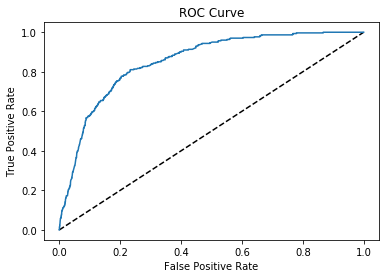

In [26]:
scaled_preds = Xgb_scaled.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, scaled_preds)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

**Scaled AUC score**

In [27]:
print(roc_auc_score(y_test, Xgb_scaled.predict_proba(X_test)[:,1], average='macro'))

0.8529942423579167


**Unscaled AUC score**

In [28]:
print(roc_auc_score(y_test, Xgb_unscaled.predict_proba(X_test)[:,1], average='macro'))

0.854328196974792


**We calibrate our model**

In [29]:
metLearn = CalibratedClassifierCV(Xgb_scaled, method='isotonic', cv=10)
metLearn.fit(X_train, y_train)
print(roc_auc_score(y_test, metLearn.predict_proba(X_test)[:,1]))

0.8529282613176824


**Another look at the ROC curve after calibrating the model**

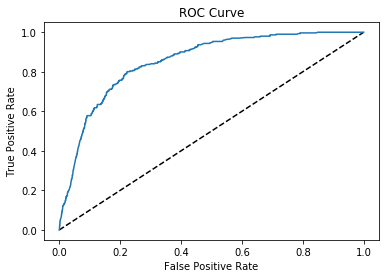

In [30]:
met = metLearn.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, met)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [31]:
probs = metLearn.predict_proba(test)

In [32]:
test_final['TARGET'] = probs[:,1]
test_final['nv'] = test_final['num_var33']+test_final['saldo_medio_var33_ult3']+test_final['saldo_medio_var44_hace2']+test_final['saldo_medio_var44_hace3']+test_final['saldo_medio_var33_ult1']+test_final['saldo_medio_var44_ult1']
test_final.loc[test_final.nv > 0, 'TARGET'] =0
test_final.loc[test_final.var15 < 23, 'TARGET'] = 0
test_final.loc[test_final.saldo_medio_var5_hace2 > 160000, 'TARGET'] = 0
test_final.loc[test_final.saldo_var33 > 0, 'TARGET'] = 0
test_final.loc[test_final.var38 > 3988596, 'TARGET'] = 0
test_final.loc[test_final.var21 > 7500, 'TARGET'] = 0
test_final.loc[test_final.num_var30 > 9, 'TARGET'] = 0
test_final.loc[test_final.num_var13_0 > 6, 'TARGET'] = 0
test_final.loc[test_final.num_var33_0 > 0, 'TARGET'] = 0
test_final.loc[test_final.imp_ent_var16_ult1 > 51003, 'TARGET'] = 0
test_final.loc[test_final.imp_op_var39_comer_ult3 > 13184, 'TARGET'] = 0
test_final.loc[test_final.saldo_medio_var5_ult3 > 108251, 'TARGET'] = 0
test_final.loc[test_final.num_var37_0 > 45, 'TARGET'] = 0
test_final.loc[test_final.saldo_var8 > 60099, 'TARGET'] = 0
test_final.loc[test_final.num_var13_largo_0 > 3, 'TARGET'] = 0
test_final.loc[test_final.imp_op_var40_comer_ult1 > 3639.87, 'TARGET'] = 0
test_final.loc[test_final.num_var5_0 > 6, 'TARGET'] = 0
test_final.loc[test_final.saldo_medio_var13_largo_ult1 > 0, 'TARGET'] = 0
test_final.loc[test_final.num_meses_var13_largo_ult3 > 0, 'TARGET'] = 0
test_final.loc[test_final.num_var20_0 > 0, 'TARGET'] = 0
test_final.loc[test_final.saldo_var13_largo > 150000, 'TARGET'] = 0
test_final.loc[test_final.num_var17_0 > 21, 'TARGET'] = 0
test_final.loc[(test_final['var15']+test_final['num_var45_hace3']+test_final['num_var45_ult3']+test_final['var36']) <= 24, 'TARGET'] = 0
test_final.loc[test_final.saldo_var5 > 137615, 'TARGET'] = 0
test_final.loc[test_final.saldo_var14 > 19053.78, 'TARGET'] = 0
test_final.loc[test_final.saldo_var17> 288188.97, 'TARGET'] = 0
test_final.loc[test_final.saldo_var26 > 10381.29, 'TARGET'] = 0

**Now we can generate a new file with our predictions**

In [33]:
submission = pd.DataFrame({"ID":test_id, "TARGET": test_final['TARGET']})
submission.to_csv("GroupA_Submission.csv", index=False)

test_final.loc[test_final.saldo_var26 > 10381.29, 'TARGET'] = 0


**Kaggle final Score 0.840377 <br> Kaggle handle: Gobbet**